In [1]:
import openslide
import numpy as np
from PIL import Image
import cv2
from glob import glob
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
df=pd.read_csv('../../data/gcu_svs/위암 생검 병리 진단지.csv')
df['number'][1]

'S22-40-2'

In [12]:
wsi_file_path="../../data/Stomach biopsy 스캔원본/"
wsi_file_list=[]
for i in range(len(df['number'])):
    wsi_file_list.append(wsi_file_path+df['number'][i]+'.mrxs')
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [13]:
for i in tqdm(range(len(wsi_file_list))):
    slide=openslide.OpenSlide(wsi_file_list[i])
    folder_name = (os.path.basename(wsi_file_list[i])).split(".")[0]

    thumbnail = np.array(slide.get_thumbnail(slide.level_dimensions[5]))
    hsv_image = cv2.cvtColor(thumbnail, cv2.COLOR_RGB2HSV)
    mask=np.where(hsv_image[:,:,0]>127,255,0).astype(np.uint8)
    Image.fromarray(mask).save('../../data/gcu_svs/mask/'+folder_name+".png")

100%|██████████| 105/105 [00:54<00:00,  1.92it/s]


In [15]:
for i in tqdm(range(len(wsi_file_list))):
    slide=openslide.OpenSlide(wsi_file_list[i])
    tile_size = int(300*(41.1/20.0))  # 각 타일 크기
    x_tiles = slide.dimensions[0] // tile_size
    y_tiles = slide.dimensions[1] // tile_size
    src_tile_size=300
    folder_name = (os.path.basename(wsi_file_list[i])).split(".")[0]
    mask = np.array(Image.open('../../data/gcu_svs/mask/'+folder_name+".png"))
    ratio=mask.shape[0]/slide.dimensions[1]
    create_dir('../../data/gcu_svs/svs/'+folder_name+"/")
    for x in range(x_tiles):
        for y in range(y_tiles):
            x_ratio_ind=[int(x*tile_size*ratio),int((x+1)*tile_size*ratio)]
            y_ratio_ind=[int(y*tile_size*ratio),int((y+1)*tile_size*ratio)]
            
            if mask[y_ratio_ind[0]:y_ratio_ind[1],x_ratio_ind[0]:x_ratio_ind[1]].mean()==0:
                continue
            region = np.array(slide.read_region((x * tile_size, y * tile_size), level=0, size=(tile_size, tile_size)))
            hsv_image = cv2.cvtColor(region[:,:,:-1], cv2.COLOR_RGB2HSV)
            ret,mask1=cv2.threshold(hsv_image[:,:,1],127,1, cv2.THRESH_OTSU)
            if ret<50:
                continue
            if mask1.sum()<tile_size*tile_size*0.2:
                continue
            Image.fromarray(region).resize((src_tile_size,src_tile_size)).save('../../data/gcu_svs/svs/'+folder_name+"/{}_{}.png".format(x,y))


100%|██████████| 105/105 [24:55<00:00, 14.24s/it]


100%|██████████| 105/105 [00:00<00:00, 363.82it/s]


Total 
WSI(caption) : 105
Patch Image : 12784
Patch Image / WSI (P/W) : 121.752
P/W .std : 102.511


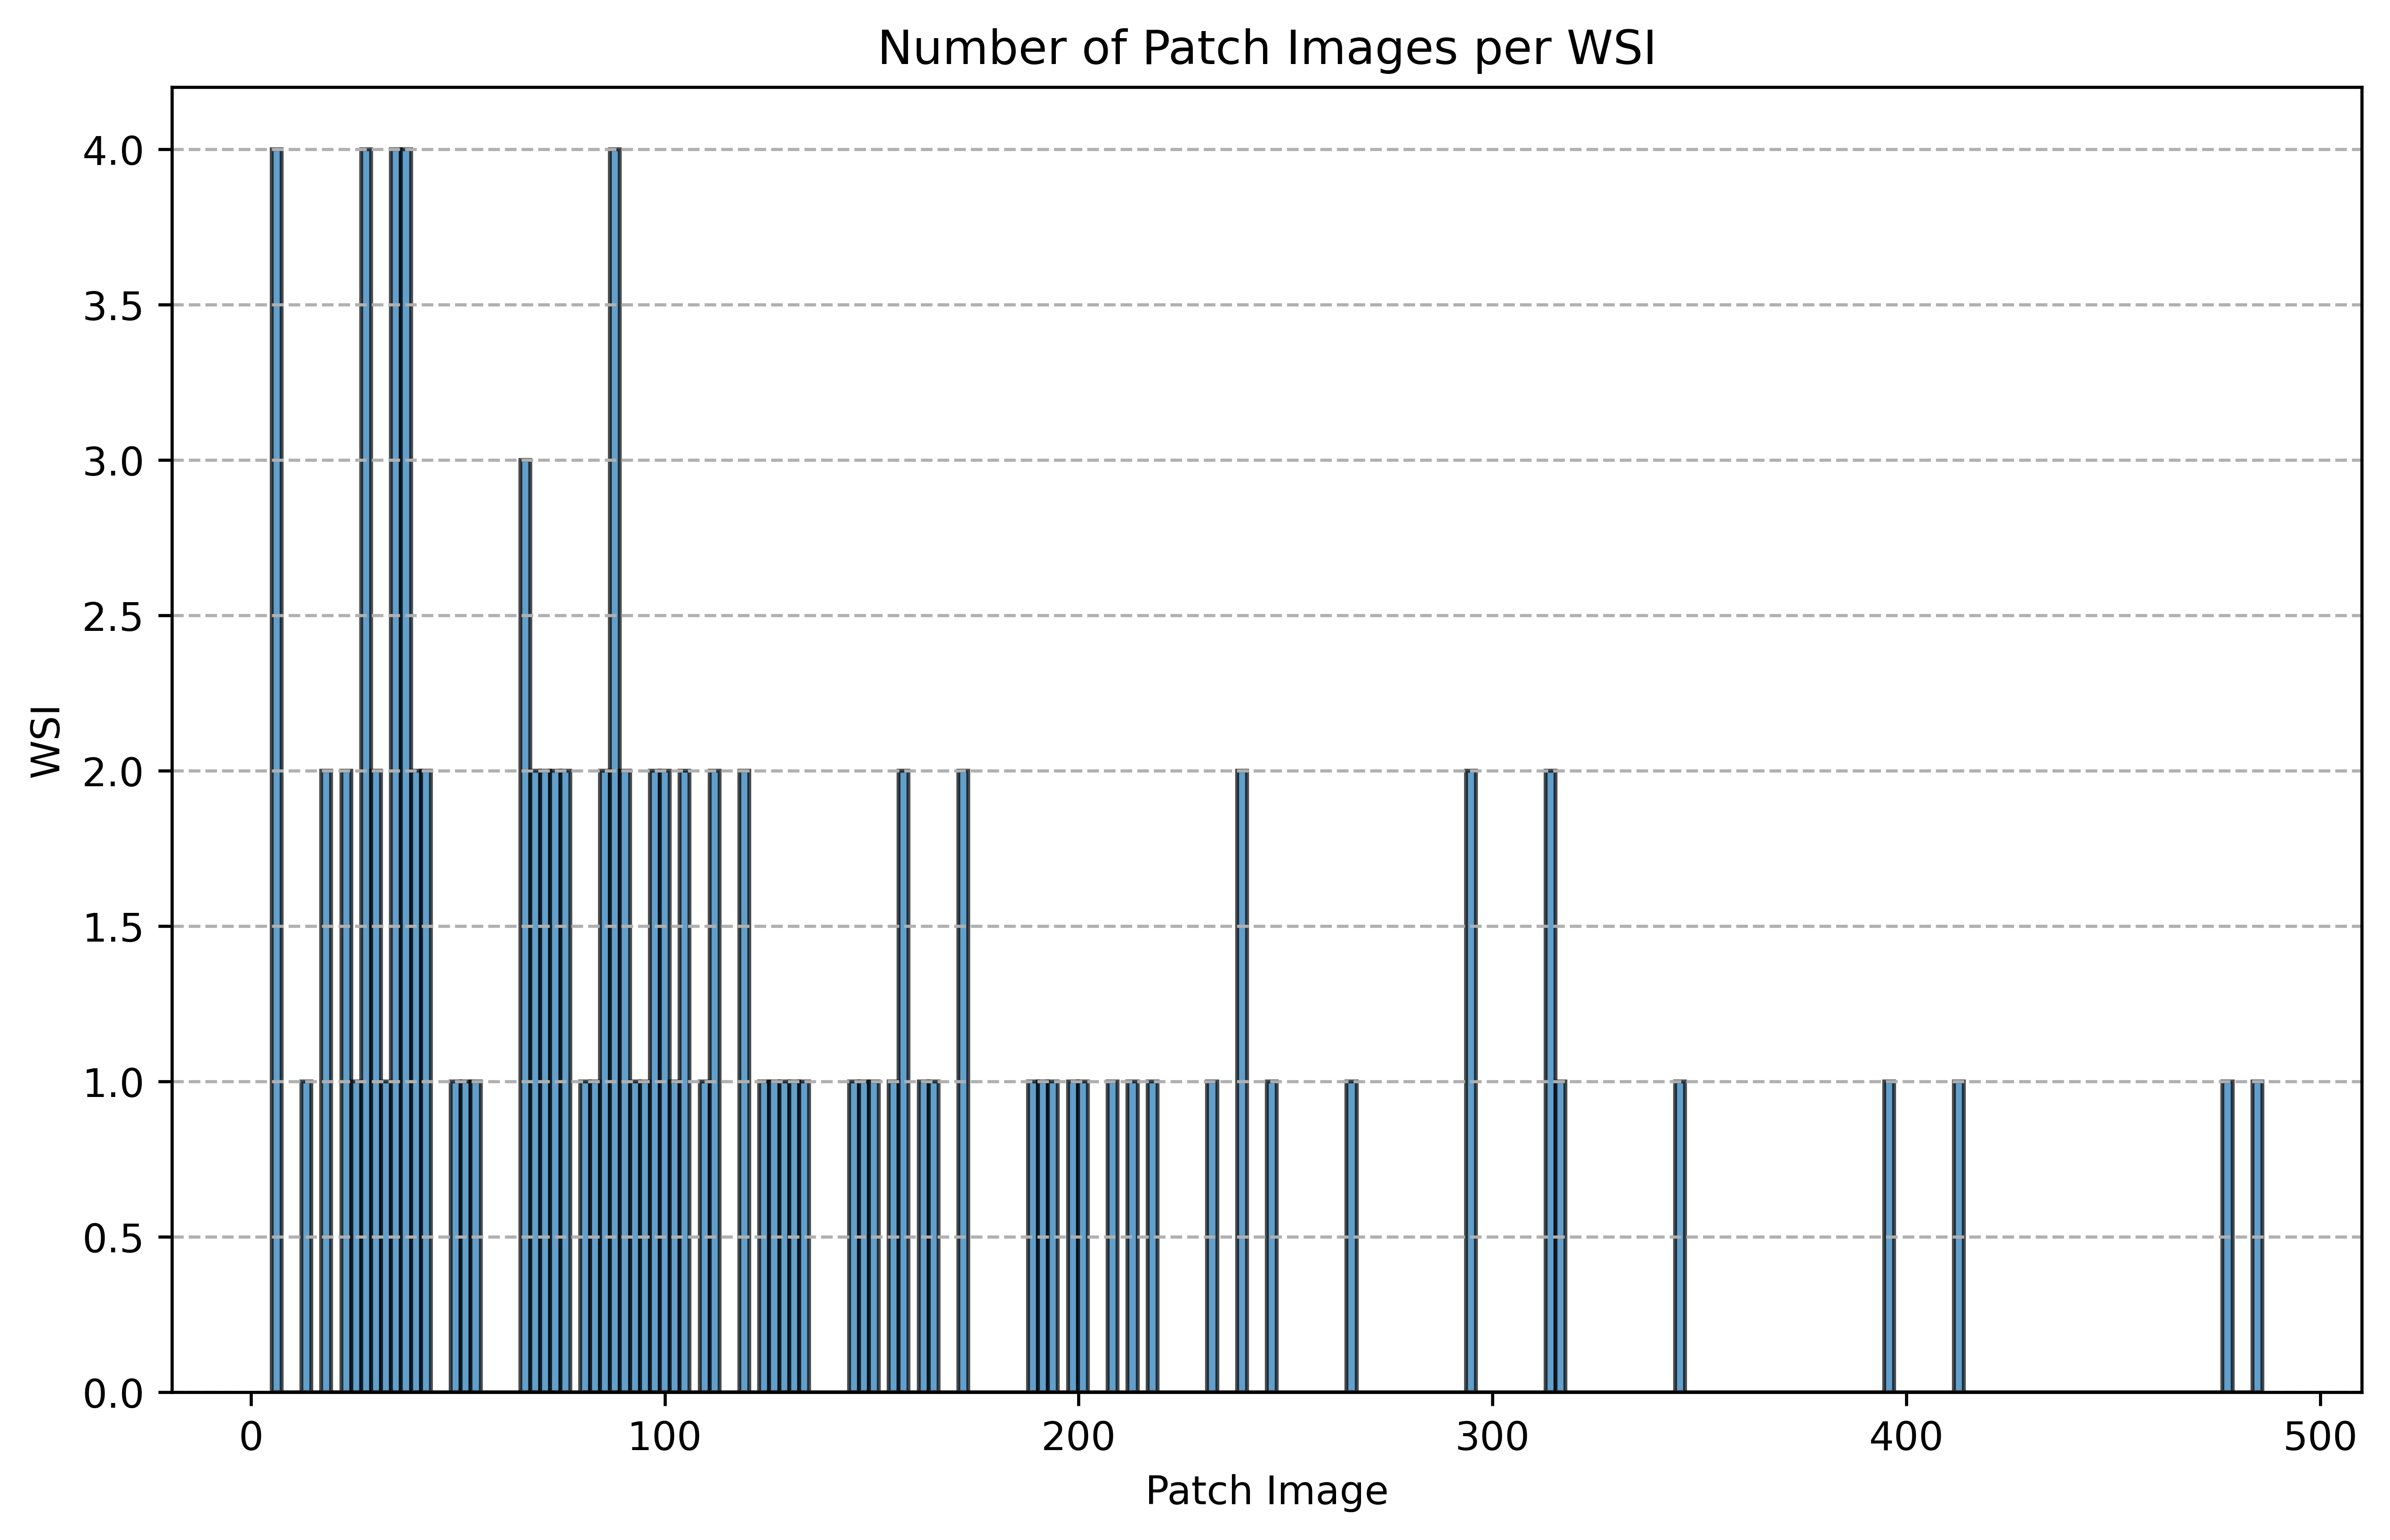

In [18]:
Folder_list=glob('../../data/gcu_svs/svs/**/')
folder_len_list = []
for i in tqdm(range(len(Folder_list))):
    folder_len_list.append(len(glob(Folder_list[i]+'*.png')))
folder_len_list = np.array(folder_len_list)
print(f'Total \nWSI(caption) : {len(Folder_list)}\nPatch Image : {folder_len_list.sum()}\nPatch Image / WSI (P/W) : {folder_len_list.mean():06.3f}\nP/W .std : {np.std(folder_len_list):06.3f}')
plt.figure(figsize=(10, 6),dpi=600)
plt.hist(folder_len_list, bins=200, edgecolor='black', alpha=0.7)
plt.title('Number of Patch Images per WSI')
plt.xlabel('Patch Image')
plt.ylabel('WSI')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [7]:
tile_size

616.5

In [ ]:
folder_name